In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/SEOP-and-NMR.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/SEOP-and-NMR/src")

Cloning into 'SEOP-and-NMR'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 379 (delta 198), reused 119 (delta 45), pack-reused 0
Receiving objects: 100% (379/379), 6.50 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [2]:
# PYTHON PACKAGES
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
import copy as cp
from tqdm.autonotebook import tqdm
np.random.seed(14)

# MY PACKAGES
import physical_constant_units as phy
import measurements as meas
import environment as env
import xenon as xe
import utils

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


# Single specie simulation without magnetic noise

In this simulation we assume there is no magnetic noise and no effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


### Single specie simulation for sigmoid like world rotation

1.0
2000
| Xenon129 Environment:
| ----------
| B0:                     0.0001
| B_noise:                -2.7216430202030785e-12
| ωd_x:                   0.0
| Ωd_x:                   0.0
| ωd_y:                   -7440.6900000000005
| Ωd_y:                   0.12909944487358055
| Ωr:                     3.720075976020836e-46
| Xenon 129:
| ----------
| gyromagnetic ratio:     -74406900.0
| T1:                     30
| T2:                     8
| K0:                     [0.0259 0.02   0.3   ]
| Kt:                     [0. 0. 0.]
| K steady:               [0. 0. 0.]


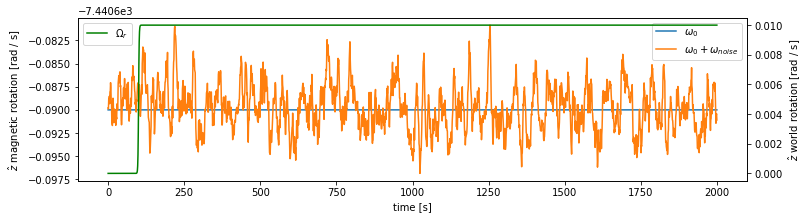

In [3]:
# solver parameters
freq = 0.001                    # [Hz]
period = 1 / freq               # [s]
num_periods = 2
t_final = num_periods * period  # [s]
dt = period / 1000              # [s]
print(dt)

steps = int(t_final // dt)
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)
print(steps)

# world rotation parameters
# wr = 30 * utils.gaussian(ts, 600, 40)                         # rad / s     
wr = 0.01 * utils.sigmoid(ts, 1, 100)                          # rad / s   
#wr = utils.ReLU(ts, x0=100, m=0.001)                          # rad / s

# wr = 0.01 * np.sin(2 * np.pi * freq * ts)             # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s
t2 = 8                                 # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
Bnoise = 1e-6 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s


# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
env129.display_params()

# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()
Xe129.set_bloch_matrix(env129)
Xe129.init_with_steady_state()



# plot world rotation
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot()
ax.plot(ts, Xe129.gamma * B0, label='$\omega_0$')
ax.plot(ts, Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$')
ax.set_ylabel('$\hat{z}$ magnetic rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax1 = ax.twinx()
ax1.plot(ts, wr, label='$\Omega_r$', color='green')
ax1.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax1.legend()
plt.show()

### Solve and plot results

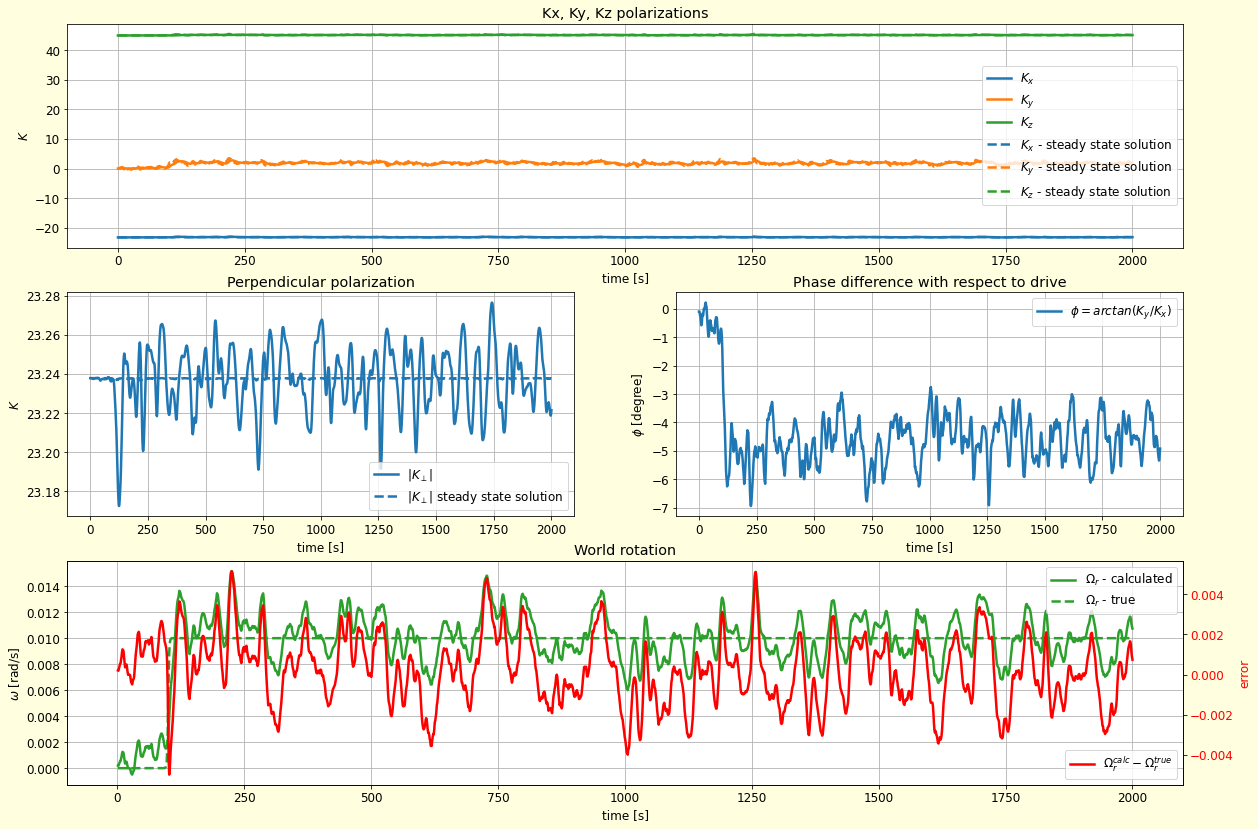

In [4]:
# run solver and save dynamics
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)

### Bandwidth and dynamic range simulations without magnetic noise ($B_{noise} = 0$)

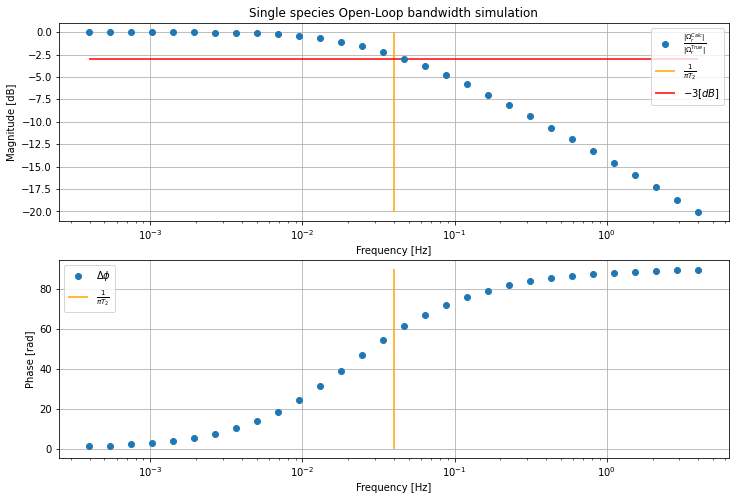

In [9]:
#@title Bandwidth simulation
t1 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2 = 8 #@param {type:"slider", min:1, max:100, step:1}
Xenon_isotop = "129" #@param ["129", "131"]

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131
    
meas.single_species_Open_Loop_bandwidth_simualtion(gyro, t1, t2)

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


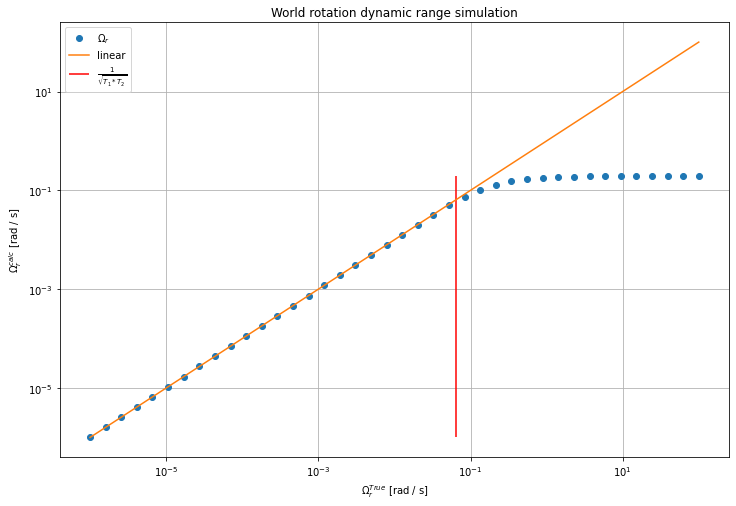

In [10]:
#@title Dynamic range
t1 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2 = 8 #@param {type:"slider", min:1, max:100, step:1}
Xenon_isotop = "129" #@param ["129", "131"]

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131

wr_amplitudes = np.logspace(-6, 2, 40)
meas.single_species_Open_Loop_dynamic_range_simulation(gyro, t1, t2, wr_amplitudes)

So we see that without magnetic noise we can extract the world rotation from the xenon129 spin measurements as long as the rotation is not too strong $$\omega_r \leq \frac{1}{\sqrt{T_1 * T_2}}$$

# Single specie simulation with magnetic noise

In this simulation we generate magnetic noise and ignore the effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\gamma^{129}_{Xe}B_{noise}}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


| Xenon 129:
| ----------
| gyromagnetic ratio:     -74406900.0
| T1:                     30
| T2:                     8
| K0:                     [0.0259 0.02   0.3   ]
| Kt:                     [0. 0. 0.]
| K steady:               [0. 0. 0.]
| Xenon129 Environment:
| ----------
| B0:                     0.0001
| B_noise:                -6.800429030936155e-12
| ωd_x:                   0.0
| Ωd_x:                   0.0
| ωd_y:                   -7440.6900000000005
| Ωd_y:                   0.12909944487358055
| Ωr:                     3.720075976020836e-46


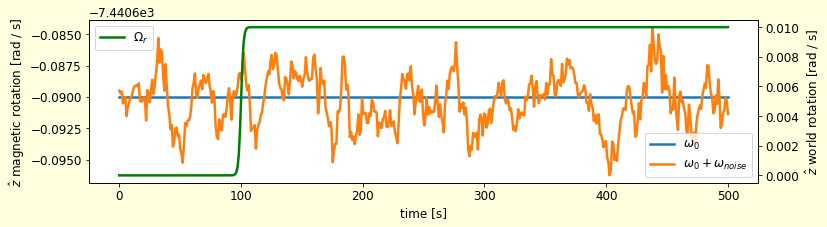

In [ ]:
# solver parameters
t_final = 500
dt = 1
steps = int(t_final // dt )
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)

# world rotation parameters
#wr = 30 * utils.gaussian(ts, 600, 40)                         # rad / s
wr = 0.01 * utils.sigmoid(ts, 1, 100)                          # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s
t2 = 8                                 # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
Bnoise = 1e-6 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s

# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()

# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
env129.display_params()

# plot world rotation
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot()
ax.plot(ts, Xe129.gamma * B0, label='$\omega_0$')
ax.plot(ts, Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$')
ax.set_ylabel('$\hat{z}$ magnetic rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax1 = ax.twinx()
ax1.plot(ts, wr, label='$\Omega_r$', color='green')
ax1.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax1.legend()
plt.show()


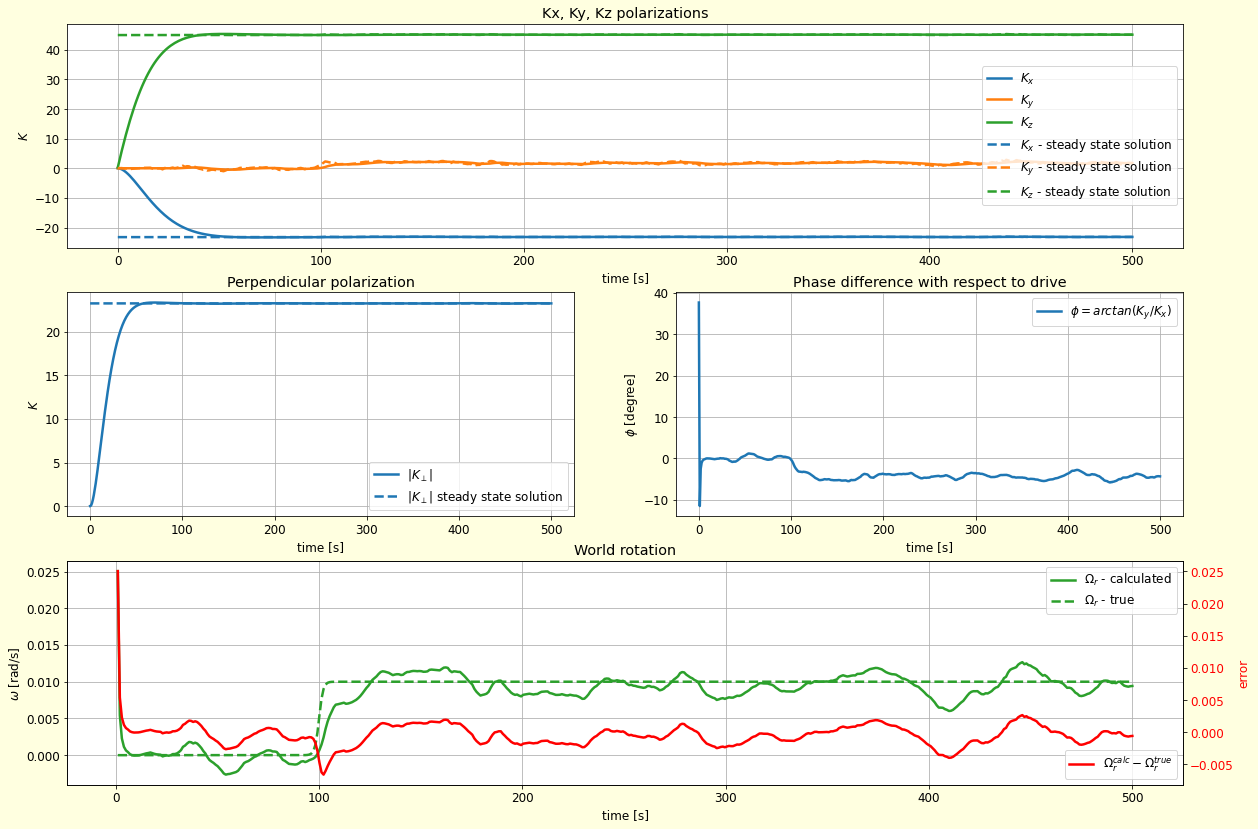

In [ ]:
# run solver and save dynamics
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)

/content/SEOP-and-NMR/src/measurements.py:83: RuntimeWarning: invalid value encountered in log10
  ax1.semilogx(freq_list, 10 * np.log10(amplitude_ratio), 'o', label=r'$\frac{|\Omega_r^{Calc}|}{|\Omega_r^{True}|}$')
/content/SEOP-and-NMR/src/measurements.py:84: RuntimeWarning: invalid value encountered in log10
  ax1.vlines(1 / t2 / np.pi, ymin=np.min(10 * np.log10(amplitude_ratio)), ymax=0,


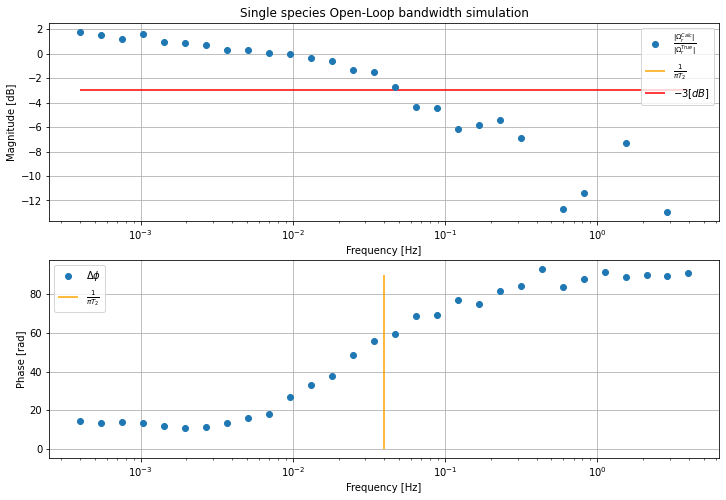

In [11]:
#@title Bandwidth simulation
t1 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2 = 8 #@param {type:"slider", min:1, max:100, step:1}
Xenon_isotop = "129" #@param ["129", "131"]
Bnoise_amplitude = 1e-6 #@param {type:"number"}

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131
    
meas.single_species_Open_Loop_bandwidth_simualtion(gyro, t1, t2, Bnoise_amp=Bnoise_amplitude)

So we see that with magnetic noise we can extract the world rotation from the xenon129 spin measurements as long as the rotation is not too strong and when the rotation spectral amplitudes are small enough so they do not map into the perpendicular phase computation.

In order to solve the problem of the magnetic noise we need to introduce another Xenon specie (131) so we can subtruct the magnetic noise. 

In [9]:
import torch
import ipywidgets as widgets
from tqdm.autonotebook import tqdm
from google.colab.widgets import Grid
from google.colab.patches import cv2_imshow
from IPython.display import HTML, display, clear_output

class Button:
    def __init__(self, description, function, function_args=None):
        self.description = description
        self.function = function
        self.function_args = function_args

        self.button = widgets.Button(description=self.description)
        self.output = widgets.Output()

        def on_button_clicked(b):
            with self.output:
                if function_args:
                    self.function(*self.function_args)
                else:
                    self.function()
            
        self.button.on_click(on_button_clicked)

    def display(self):
        display(self.button, self.output)


def runtime_details_block():
    def button_func():
        print(f'torch {torch.__version__}')
        if torch.cuda.is_available():
            gpu_data = torch.cuda.get_device_properties(0)
            gpu_name = gpu_data.name
            gpu_mem  = f'{gpu_data.total_memory*1e-9:.02f} Gb'
            print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
        else:
            print('CPU')

    button = Button(description="Show Runtime Details", function=button_func)
    button.display()



################################################################################
#                                Create Grid
################################################################################

grid = Grid(1, 2)
for i, _ in enumerate(grid):
    if i==0:
        runtime_details_block()
    if i==1:
        runtime_details_block()

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Show Runtime Details', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Show Runtime Details', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>